In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import math
import seaborn as sns
from copy import deepcopy
from collections import defaultdict

sns.set()

In [2]:
train_data = pd.read_csv("train-1542197608821.csv")
test_data = pd.read_csv("test-1542197608821.csv")

train_data.info()
train_data.head(3)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8001 entries, 0 to 8000
Data columns (total 27 columns):
rally                                 8001 non-null int64
serve                                 8001 non-null int64
hitpoint                              8001 non-null object
speed                                 8001 non-null float64
net.clearance                         8001 non-null float64
distance.from.sideline                8001 non-null float64
depth                                 8001 non-null float64
outside.sideline                      8001 non-null bool
outside.baseline                      8001 non-null bool
player.distance.travelled             8001 non-null float64
player.impact.depth                   8001 non-null float64
player.impact.distance.from.center    8001 non-null float64
player.depth                          8001 non-null float64
player.distance.from.center           8001 non-null float64
previous.speed                        8001 non-null float64
prev

,rally,serve,hitpoint,speed,net.clearance,distance.from.sideline,depth,outside.sideline,outside.baseline,player.distance.travelled,...,previous.depth,opponent.depth,opponent.distance.from.center,same.side,previous.hitpoint,previous.time.to.net,server.is.impact.player,outcome,gender,ID
0,4,1,B,35.515042,-0.021725,3.474766,6.797621,False,False,1.467570,...,0.705435,12.5628,2.0724,True,F,0.445318,False,UE,mens,8644
1,4,2,B,33.382640,1.114202,2.540801,2.608708,False,True,2.311931,...,3.856600,12.3544,5.1124,False,B,0.432434,False,FE,mens,1182
2,23,1,B,22.316690,-0.254046,3.533166,9.435749,False,False,3.903728,...,2.908892,13.8620,1.6564,False,F,0.397538,True,FE,mens,9042


Get the columns list of categorical data. Find columns to drop based on analysis

In [3]:
#categorical data of given data set
categorical_cols = ['outcome']

#Columns to be dropped
cols2drop = ['id', 'gender', 'same.side', 'server.is.impact.player', 
             'outside.baseline', 'previous.hitpoint', 'hitpoint', 'rally', 'serve', 
             'outside.sideline', 'player.distance.from.center', 'depth', 
             'previous.time.to.net', 'player.impact.distance.from.center', 
             'opponent.distance.from.center']



Feature Engineering

In [5]:
def feature_engineer(data):
    
    data['speed.difference'] = data['speed'] - data['previous.speed']

    #Actual distance of point-ending shot bounce from the sideline   
    data['true.dis.from.SL'] = [dist if not boolean else (dist * -1) 
                                           for dist, boolean in 
                                           zip(data['distance.from.sideline'], 
                                               data['outside.sideline'])]

    #Actual distance of point-ending shot bounce from the baseline
    data['true.dis.from.BL'] = [dist if not boolean else (dist * -1) 
                                           for dist, boolean in 
                                           zip(data['depth'], 
                                               data['outside.baseline'])]
    return data
 
# Apply Feature Engineering
Train_data = feature_engineer(train_data)
Test_data = feature_engineer(test_data)
Train_data.head()



,rally,serve,hitpoint,speed,net.clearance,distance.from.sideline,depth,outside.sideline,outside.baseline,player.distance.travelled,...,same.side,previous.hitpoint,previous.time.to.net,server.is.impact.player,outcome,gender,id,speed.difference,true.dis.from.SL,true.dis.from.BL
0,4,1,B,35.515042,-0.021725,3.474766,6.797621,False,False,1.467570,...,True,F,0.445318,False,UE,mens,8644,3.201450,3.474766,6.797621
1,4,2,B,33.382640,1.114202,2.540801,2.608708,False,True,2.311931,...,False,B,0.432434,False,FE,mens,1182,-0.678148,2.540801,-2.608708
2,23,1,B,22.316690,-0.254046,3.533166,9.435749,False,False,3.903728,...,False,F,0.397538,True,FE,mens,9042,-17.489938,3.533166,9.435749
3,9,1,F,36.837309,0.766694,0.586885,3.342180,True,False,0.583745,...,True,B,0.671984,True,UE,mens,1222,11.818491,-0.586885,3.342180
4,4,1,B,35.544208,0.116162,0.918725,5.499119,False,False,2.333456,...,False,F,0.340411,False,W,mens,4085,-1.246771,0.918725,5.499119


XGBoost can not handle categorial data, so encode them

In [6]:
def encode(train, test):
    
    # Retain All LabelEncoder as a dictionary
    d = defaultdict(LabelEncoder)
    
    # Encode all the columns
    train[categorical_cols] = train[categorical_cols].apply(lambda x: d[x.name].fit_transform(x))
    test_ids = test['id']

    # Making a deepcopy so we can encode the test data (test data does not have an outcome column)
    temp = deepcopy(categorical_cols)
    temp.remove('outcome')
    e = deepcopy(d)
    del e['outcome']  
    test[temp] = test[temp].apply(lambda x: e[x.name].transform(x))
    
    # Drop the unecessary features
    train = train.drop(cols2drop, axis=1) 
    test = test.drop(cols2drop + ['outcome'], axis=1)
    
    return train, test, test_ids, d
    
# Encode Data
TrainData, TestData, test_ids , dict_data = encode(Train_data, Test_data)
TrainData.shape
TrainData.head()
TrainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8001 entries, 0 to 8000
Data columns (total 15 columns):
speed                              8001 non-null float64
net.clearance                      8001 non-null float64
distance.from.sideline             8001 non-null float64
player.distance.travelled          8001 non-null float64
player.impact.depth                8001 non-null float64
player.depth                       8001 non-null float64
previous.speed                     8001 non-null float64
previous.net.clearance             8001 non-null float64
previous.distance.from.sideline    8001 non-null float64
previous.depth                     8001 non-null float64
opponent.depth                     8001 non-null float64
outcome                            8001 non-null int64
speed.difference                   8001 non-null float64
true.dis.from.SL                   8001 non-null float64
true.dis.from.BL                   8001 non-null float64
dtypes: float64(14), int64(1)
memory usa

Divide the training data as  descriptive  and target features

In [7]:
TrainData_ip = TrainData.loc[:, TrainData.columns != 'outcome']
TrainData_op = TrainData['outcome']

TrainData_ip.shape


(8001, 14)

model cross validation.

In [8]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

CV = 4

model_xgb = XGBClassifier(n_estimators=100, random_state= 1, learning_rate= 0.1, 
                               subsample= 0.9, colsample_bytree= 1.0, max_depth= 5, 
                               eval_metric= 'mlogloss', min_child_weight= 1)

model_accuracy = cross_val_score(model_xgb, TrainData_ip, TrainData_op, 
                        scoring='accuracy', cv = CV, n_jobs=-1)


y_pred = cross_val_predict(model_xgb, TrainData_ip, TrainData_op,cv=4)
print("Number of k-folds = " + str(CV))

print("Model Accuracy  {:.4%}".format(np.mean(model_accuracy)))

TrainData_ip.describe()


Number of k-folds = 4
Model Accuracy  87.1892%


,speed,net.clearance,distance.from.sideline,player.distance.travelled,player.impact.depth,player.depth,previous.speed,previous.net.clearance,previous.distance.from.sideline,previous.depth,opponent.depth,speed.difference,true.dis.from.SL,true.dis.from.BL
count,8001.000000,8001.000000,8001.000000,8001.000000,8001.000000,8001.000000,8001.000000,8001.000000,8001.000000,8001.000000,8001.000000,8001.000000,8001.000000,8001.000000
mean,30.806938,0.629658,1.467630,2.690463,11.899694,12.253954,28.763676,0.821562,2.193420,4.218717,12.616810,2.043263,1.189015,3.897214
std,7.298917,0.982504,1.108697,1.713136,2.788231,2.039085,6.477470,0.674663,1.038942,2.052946,2.075401,10.148685,1.403382,3.774865
min,5.176078,-0.998184,0.000497,0.000000,2.156000,1.389800,8.449117,0.028865,0.000164,0.000467,2.161200,-35.123991,-7.569757,-11.824890
25%,26.770290,-0.027092,0.539500,1.444233,11.221400,11.374200,24.033218,0.404815,1.354458,2.733674,12.082400,-4.390476,0.227109,0.836682
50%,32.417690,0.445870,1.210847,2.360894,12.691800,12.551600,29.793417,0.658382,2.168822,4.126864,12.901600,2.207498,1.096960,3.780631
75%,35.681431,0.970844,2.215955,3.565853,13.553000,13.498000,33.581003,1.021397,3.022677,5.595515,13.712800,8.973229,2.165826,7.019839
max,55.052795,12.815893,7.569757,14.480546,18.125600,18.745800,54.207506,6.730275,4.114361,9.997963,20.211000,35.708383,4.112798,11.886069


Determine features which are important by building the model.
Create training and validation sets

Accuracy: 87.7577%
----------------
('speed', 0.03289792)
('net.clearance', 0.14562167)
('distance.from.sideline', 0.042089984)
('player.distance.travelled', 0.058538944)
('player.impact.depth', 0.06434446)
('player.depth', 0.042089984)
('previous.speed', 0.06724722)
('previous.net.clearance', 0.07160135)
('previous.distance.from.sideline', 0.06386067)
('previous.depth', 0.06240929)
('opponent.depth', 0.09966134)
('speed.difference', 0.07740687)
('true.dis.from.SL', 0.07208515)
('true.dis.from.BL', 0.10014514)


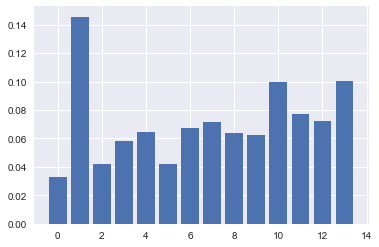

In [9]:
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

train_XX, val_XX = train_test_split(TrainData, test_size=0.2, shuffle=True)
X_train = train_XX.loc[:, train_XX.columns != 'outcome']
y_train = train_XX['outcome']
X_val = val_XX.loc[:, val_XX.columns != 'outcome']
y_val = val_XX['outcome']

myy_model = XGBClassifier(eval_metric='mlogloss')
myy_model.fit(X_train, y_train)

y_pred = myy_model.predict(X_val)

mens_acc = accuracy_score(y_val, y_pred)
print("Accuracy: {:.4%}".format(mens_acc))

print('----------------')

for x in zip(TrainData_ip,myy_model.feature_importances_):
    print(x)

plt.bar(range(len(myy_model.feature_importances_)), myy_model.feature_importances_)
plt.show()

Paramter Tuning- RandomizedSearchCV. It iterates over several paramter values and finds the best one with less computational power. 

In [10]:
from sklearn.model_selection import GridSearchCV

cv_params = {'learning_rate': [0.001, 0.01, 0.1]}
ind_params = {'n_estimators': 100, 'seed':0,  'subsample': 0.9, 'colsample_bytree':1.0,
              'objective': 'multi:softprob', 'max_depth': 5, 'min_child_weight': 1}
optimized_GBM = GridSearchCV(XGBClassifier(**ind_params), 
                             cv_params, scoring = 'neg_log_loss', cv = 4, n_jobs = -1, verbose=3) 

optimized_GBM.fit(TrainData_ip, TrainData_op)
print('Final Optimzed Scores')
optimized_GBM.grid_scores_

Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV] learning_rate=0.001 .............................................
[CV] learning_rate=0.001 .............................................
[CV] learning_rate=0.001 .............................................
[CV] learning_rate=0.001 .............................................
[CV] learning_rate=0.01 ..............................................
[CV] learning_rate=0.01 ..............................................
[CV] learning_rate=0.01 ..............................................
[CV] learning_rate=0.01 ..............................................
[CV] ... learning_rate=0.001, score=-1.0110963460741906, total=   4.4s
[CV] learning_rate=0.1 ...............................................
[CV] ... learning_rate=0.001, score=-1.0117331569281773, total=   4.6s
[CV] learning_rate=0.1 ...............................................
[CV] .... learning_rate=0.001, score=-1.012665096964393, total=   4.7s
[CV] .... learnin

[Parallel(n_jobs=-1)]: Done   2 out of  12 | elapsed:    4.8s remaining:   23.8s


[CV] .... learning_rate=0.01, score=-0.6093795228863191, total=   4.8s
[CV] ... learning_rate=0.001, score=-1.0121323285906716, total=   4.9s
[CV] .... learning_rate=0.01, score=-0.6120947082896998, total=   4.9s


[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    5.1s remaining:    3.6s


[CV] ..... learning_rate=0.1, score=-0.3387665952607937, total=   2.9s
[CV] ..... learning_rate=0.1, score=-0.3120920359988281, total=   2.7s
[CV] ..... learning_rate=0.1, score=-0.3109484010608051, total=   2.6s
[CV] ..... learning_rate=0.1, score=-0.3491803473199421, total=   2.6s


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    7.8s finished


Final Optimzed Scores


[mean: -1.01191, std: 0.00057, params: {'learning_rate': 0.001},
 mean: -0.61471, std: 0.00411, params: {'learning_rate': 0.01},
 mean: -0.32775, std: 0.01664, params: {'learning_rate': 0.1}]

Build the model with optimized parameters

In [11]:
model_xgb = XGBClassifier(n_estimators=100, seed= 0, learning_rate= 0.1, subsample= 0.9, 
                               colsample_bytree= 0.8, eval_metric= 'mlogloss', max_depth= 5, 
                               min_child_weight= 1, gamma= 0)

model_xgb.fit(TrainData_ip, TrainData_op)
test_pred = pd.DataFrame(model_xgb.predict_proba(TestData))



Writing to csv file

In [12]:
combined_test_predictions = test_pred
test_pred.columns = ['FE', 'UE', 'W']
test_pred.reset_index(inplace=True, drop=True)
test_pred.head(5)

print(test_pred.shape)

fr = pd.DataFrame(test_pred.idxmax(axis=1))
fr.to_csv('raghavnov25.csv')

(1999, 3)
